In [44]:
## required packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

In [45]:
class SoccerDataset(object):
    def __init__(self):
        self.DATA_DIR='data/SoccerData.xlsx'
        self.sheet='All Data'
        self.data=self.load_data()
    #load data
    def load_data(self):
        data = pd.read_excel(self.DATA_DIR, self.sheet, index_col=None)#reading data in particular sheet 'All Data'
        return data
    
    ##get list of column names
    def getColumns(self):
        return self.data.columns
    
    ##shows non null value caount and data type per column 
    def getDataInfo(self):
        return self.data.info()

In [46]:
SoccerDataset=SoccerDataset()
data=SoccerDataset.data

<b>## Data Cleansing ##</b>

In [47]:
## get info about data
SoccerDataset.getDataInfo()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24830 entries, 0 to 24829
Data columns (total 81 columns):
league           24830 non-null object
teams_no         24830 non-null int64
date             24830 non-null datetime64[ns]
home_team        24830 non-null object
away_team        24830 non-null object
home_odd         24830 non-null float64
draw_odd         24830 non-null float64
away_odd         24830 non-null float64
h_played         24830 non-null int64
a_played         24830 non-null int64
ph_ladder5       24830 non-null int64
ph_ladder4       24830 non-null int64
ph_ladder3       24830 non-null int64
ph_ladder2       24830 non-null int64
ph_ladder1       24830 non-null int64
h_ladder         24830 non-null int64
pa_ladder5       24830 non-null int64
pa_ladder4       24830 non-null int64
pa_ladder3       24830 non-null int64
pa_ladder2       24830 non-null int64
pa_ladder1       24830 non-null int64
a_ladder         24830 non-null int64
h_won            24830 non-null int64

From these informations we can already see that some features won't be relevant in our exploratory analysis as there are too much missing values (such as Unnamed: 79 and Unnamed: 80). However, from our exploratory analysis, features such as BTS, H1H, A1H, H2H, A2H, teams_no has no significant role to predict result.  Plus there is so much features to analyse that it may be better to concentrate on the ones which can give us real insights. Let's just remove the features with 50% or more NaN values.

In [48]:
# drop columns with more than 50% values missed
data_clean = data[[column for column in data if data[column].count() / len(data) >= 0.5]]
print("List of dropped columns:", end=" ")
for c in data.columns:
    if c not in data_clean.columns:
        print(c, end=", ")
print('\n')
data = data_clean

List of dropped columns: Unnamed: 79, Unnamed: 80, 



In [49]:
data.shape

(24830, 79)

## Lets remove features with no significant dependancy to other features

##One more thing is we inspect correlation matrix, date feature is less related to the other but one can further explore its impact with playing frequently or at the of the game has impact on the result or not. But for now I will drop the coloumn.

From our exploratory analysis (See histogram distrbution of each features), we can see that critcal features are aroung team stats and odds feature. By skiping home_team and away_team features to game and we can create two separate data as result feature dependa on two. 
So, for now I will create the data for Home team using RESULT coulumn "HOME" as "WIN" and later I will refine the code for away team.

In [50]:
del_col_list = ['home_team','away_team','teams_no', 'h_half','a_half', 'a_final', 'h_final', 'BTS', 'H1H', 
                'date', 'A1H','H2H', 'A2H', 'league']

data=data.drop(del_col_list, axis=1)

data.shape

(24830, 65)

In [51]:
## our data has single categorical feature RESULT after previous preprocessing step 
## but let create function for labeling categorical features
# Categorical boolean mask. I am using lablelEncoder

from sklearn.preprocessing import LabelEncoder# instantiate labelencoder object

##function to encode all categorical features
def encode_categorical_features(df):
    lblEncoder = LabelEncoder()
    categorical_feature_mask = df.dtypes==object# filter categorical columns using mask and turn it into a list
    categorical_cols = df.columns[categorical_feature_mask].tolist()
    # apply le on categorical feature columns
    df[categorical_cols] = df[categorical_cols].apply(lambda col: lblEncoder.fit_transform(col))
    return df
##Again tranisform target feature RESULT
data=encode_categorical_features(data)
data.head(10)

,home_odd,draw_odd,away_odd,h_played,a_played,ph_ladder5,ph_ladder4,ph_ladder3,ph_ladder2,ph_ladder1,...,h_fail,a_fail,h_clean_h,a_clean_a,h_fail_h,a_fail_a,h_goal_signal,a_goal_signal,Ladder_signal,RESULT
0,2.630,2.97,3.24,19,19,20,20,20,20,17,...,47.368,26.316,55.556,40.000,33.333,10.000,0.444444,-0.200000,-14,1
1,1.980,3.25,4.69,19,19,11,8,7,7,6,...,36.842,52.632,44.444,22.222,22.222,55.556,0.444444,0.333333,9,1
2,2.000,3.52,4.14,19,19,9,5,9,5,10,...,26.316,31.579,0.000,20.000,20.000,20.000,0.500000,0.400000,5,2
3,2.820,3.06,2.91,19,19,16,16,16,16,16,...,36.842,21.053,30.000,33.333,40.000,22.222,0.000000,-0.333333,-12,1
4,2.100,3.21,4.20,19,19,6,7,4,6,4,...,10.526,42.105,40.000,33.333,10.000,33.333,0.800000,0.000000,10,2
5,1.448,4.28,9.93,19,19,2,1,2,2,2,...,21.053,42.105,44.444,50.000,22.222,50.000,1.333333,0.300000,10,2
6,2.430,3.21,3.30,19,19,19,19,17,18,18,...,42.105,26.316,22.222,40.000,33.333,50.000,-0.111111,0.600000,-10,2
7,3.020,2.93,2.83,19,19,18,18,19,19,20,...,42.105,42.105,30.000,40.000,50.000,50.000,-0.200000,0.300000,-8,0
8,1.096,11.90,34.38,19,19,1,1,1,1,1,...,5.263,26.316,37.500,11.111,0.000,44.444,2.625000,1.000000,15,2
9,2.090,3.27,4.10,19,19,10,6,9,10,6,...,31.579,36.842,55.556,22.222,22.222,33.333,1.000000,0.000000,11,2


Duplicate columns has no impact as a feature. So, as one type of feature dimension reduction we will check for existance of duplicate column and remove it.

Interestingly no duplicated column exist. Lets again check for conistant features to minimize problem at data spliting. We have two option to go with this. One is using separate feature and train independantly, the other is removing. I will go with the latter one.

## Fill missed value

In [62]:
# replacing all the zeros from odds features to some meaningfull values.
cols = ['home_odd','draw_odd','away_odd']
#First lets change it to dataframe understandable null value
data[cols] = data[cols].replace(0, np.nan)

# Instead of droping zero filled odds feature value, I will use popular median approach
median = data['home_odd'].median()
data['home_odd'].fillna(median, inplace=True)

median = data['draw_odd'].median()
data['draw_odd'].fillna(median, inplace=True)

median = data['away_odd'].median()
data['away_odd'].fillna(median, inplace=True)

## There is also missing value for h_goal_signal, a_goal_signal, and Ladder_signal. So I will do same thing
median = data['h_goal_signal'].median()
data['h_goal_signal'].fillna(median, inplace=True)

median = data['a_goal_signal'].median()
data['a_goal_signal'].fillna(median, inplace=True)

median = data['Ladder_signal'].median()
data['Ladder_signal'].fillna(median, inplace=True)


data.shape

(24830, 65)

Next I will focus on detecting and removing outliers. Because some fields are filled manually as indicated looking for outliers is important to standardize the data. First I will plot for existance (i.e, filtering out outliers based on fixed percentile values. I will use 95%) of outlier then using popular perecentage based detection mechanisim I will remove.

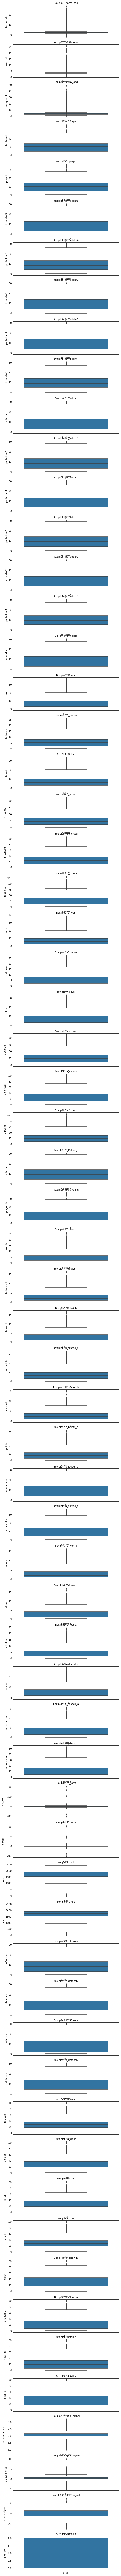

In [63]:
#dealing with outliers
# The following code snipate checks for existance of outliers in data based on columns
col_names = data.columns.values
fig, ax = plt.subplots(len(col_names), figsize=(8,200))
for i, col_val in enumerate(col_names):
    sns.boxplot(y=data[col_val], ax=ax[i])
    ax[i].set_title('Box plot - {}'.format(col_val), fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)

plt.show()

In the above plot, black dots are outliers and as we can observe from the graph all variables except RESULT has outlier. The blue colored box is the IQR range.
<ul><li>The interquartile range (IQR) is the range covered by the middle 50% of the data.
    IQR = Q3 – Q1, the difference between the third and first quartiles. </li>
<li>The first quartile (Q1) is the value such that one quarter (25%) of the data points fall below it, or the median of the bottom half of the data. </li>
<li>The third quartile is the value such that three quarters (75%) of the data points fall below it, or the median of the top half of the data.</li>
<li>The IQR can be used to detect outliers using the 1.5(IQR) criteria. Outliers are observations that fall below Q1 – 1.5(IQR) or above Q3 + 1.5(IQR).</li>
    </ul>

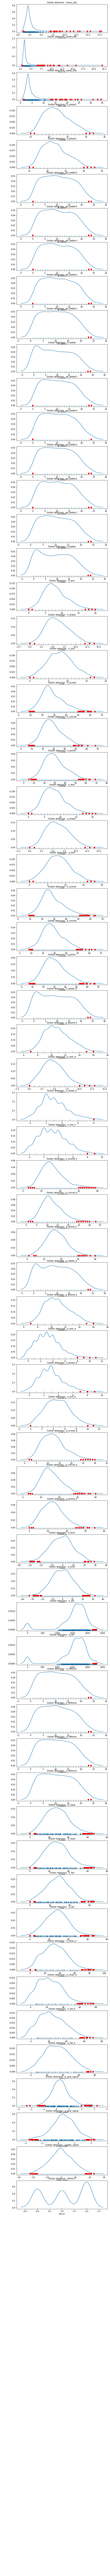

In [64]:
## Percentage based outlier removal.
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

col_names = data.columns.values ##

fig, ax = plt.subplots(len(col_names), figsize=(8,200))

for i, col_val in enumerate(col_names):
    x = data[col_val][:1000]
    sns.distplot(x, ax=ax[i], rug=True, hist=False)
    outliers = x[percentile_based_outlier(x)]
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    ax[i].set_title('Outlier detection - {}'.format(col_val), fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)

plt.show()

The values marked with a dot below in the x-axis of the graph are the ones that are removed from the column based on the set threshold percentile (95 in our case), and is also the default value when it comes to percentile-based outlier removal.

Next I will apply data balacing per class levels. As we have observed at exploratory analysis data target class are partially imbalanced. So, I will use popular Over-sampling followed by under-sampling using SMOTE. Instead of affecting only over-sampled or under-sampled class, using Over-sampling followed by under-sampling approach good in handling data imbalance. 

In [89]:
## Data Balancing
# Function to plot class distribution 
def plot_smote(X,y):
    # scatter plot, dots colored by class value
    from pandas import DataFrame
    from matplotlib import pyplot
    colors = {0:'red', 1:'blue', 2:'green'}
    df = DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    ig, ax = pyplot.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    pyplot.show()
    # split data into X and y

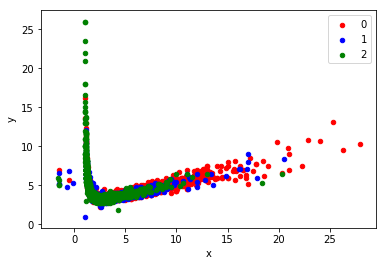

In [88]:
## Lets first shuffle our data. Shuffling enables us to control data leakage.
from sklearn.utils import shuffle
data = shuffle(data)
y = data.RESULT
X = data.drop(['RESULT'], axis=1)
from imblearn.combine import SMOTETomek
smt = SMOTETomek(ratio='auto')
X, Y = smt.fit_sample(X, y)
plot_smote(X,Y)

Lets split data to train, test, and validation. I will follow what is ordered. training (60%), validation(30%) and test(10%) 

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [111]:
# Scale the data then split data into train and test sets
scaler = Normalizer().fit(X)
X = scaler.transform(X)
seed = 7
test_size = 0.10
validation_size=0.30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
X_train,X_valid,y_train,y_valid=train_test_split(X_train, y_train, test_size=validation_size, random_state=seed)

print('Training Split x:{},y:{}'.format(X_train.shape[0],y_train.shape[0]))
print('Test Split x:{},y:{}'.format(X_test.shape[0],y_test.shape[0]))
print('Validation Split x:{},y:{}'.format(X_valid.shape[0],y_valid.shape[0]))


Training Split x:17430,y:17430
Test Split x:2767,y:2767
Validation Split x:7471,y:7471


Next I will create different models using different ALgorthms. I will run 5 fold cross validation for all algorithms

In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import time

def randomForest(X_train, X_test, y_train, y_test):
  
    # parameters = {'n_estimators': [10, 20, 30, 50], 'max_depth': [2, 3, 4]}

    clf = RandomForestClassifier(max_depth=4, n_estimators=20)
    # clf = GridSearchCV(alg, parameters, n_jobs=4)
    clf.fit(X_train, y_train)
    print('RandomForest Classier')
    print("Score: ", clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    print("F1 score is: {}".format(f1_score(y_test, y_pred,average='micro')))

def neural_nets(X_train, X_test, y_train, y_test):
    print('MLP\n')
    clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100,))
    clf.fit(X_train, y_train)
    print("Score: ", clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    print("F1 score is: {}".format(f1_score(y_test, y_pred,average='micro')))
def xgb_classifier(X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_train)
    print(confusion_matrix(y, y_pred))
    

Using TensorFlow backend.


In [ ]:
print('start training of LightGBM...')
import lightgbm as lgb
from sklearn.model_selection import KFold

n_predict = 0
valid = np.zeros( (len(test_ID),) )
for fold_id, (IDX_train, IDX_test) in enumerate(KFold(n_splits=10, random_state=random_state, shuffle=False).split(Y)):
	X_train = X[IDX_train]
	X_test = X[IDX_test]
	Y_train = Y[IDX_train]
	Y_test = Y[IDX_test]
	params = {'application': 'regression',
			  'boosting': 'gbdt',
			  'metric': 'rmse',
			  'num_leaves': 80,
			  'max_depth': 11,
			  'learning_rate': 0.01,
			  'bagging_fraction': 0.9,
			  'feature_fraction': 0.8,
			  'min_split_gain': 0.01,
			  'min_child_samples': 150,
			  'min_child_weight': 0.1,
			  'verbosity': -1,
			  'data_random_seed': 3,
			  'early_stop': 100,
			  'verbose_eval': 100,
			  'num_rounds': 10000}

	lgb_params = {
		"objective" : "regression",
		"metric" : "mse",
		"max_depth" : 2,
		"num_leaves" : 2,
		"learning_rate" : 0.01,
		"bagging_fraction" : 0.3,
		"feature_fraction" : 0.15,
		"lambda_l1" : 5,
		"lambda_l2" : 5,
		"bagging_seed" : fold_id+random_state,
		"verbosity" : 1,
		'random_state': 2018,
		"seed": fold_id+random_state
	}
	lgb_params = {
		'boosting_type': 'gbdt',
		'objective': 'regression',
		'learning_rate': 0.005,
		'subsample': .8,
		'colsample_bytree': 0.8,
		'min_split_gain': 0.006,
		'min_child_samples': 150,
		'min_child_weight': 0.1,
		'max_depth': 17,
		'n_estimators': 10000,
		'num_leaves': 80,
		'silent': -1,
		'verbose': -1,
		'max_depth': 11,
		'random_state': 2018
	}
	lgtrain = lgb.Dataset(X_train, label=Y_train)
	lgtest = lgb.Dataset(X_test, label=Y_test)
	evals_result = {}
	lgb_clf = lgb.train(lgb_params, lgtrain, 35000,
						valid_sets=[lgtrain, lgtest],
						early_stopping_rounds=500,
						verbose_eval=2000,
						evals_result=evals_result)
	valid += lgb_clf.predict( Xt ).reshape((-1,))
	n_predict += 1
	if time.time() - start_tiem > 6900:
		break

valid = (valid / n_predict) + yt_nb
valid = np.clip( valid, 0.0, 1.0 )
print('save result.')